# Sensitivity testing

*Problem*: We hypothesize that there exists a nudge of size $\eta$ for which driver-node as identified by mutual information decay will match with the driver-node for causal impact. Currently, the nudge is determined a priori with no real foundation as to why it is set to some value. This notebook as the purposed of looking for if there exists a nudge $\eta$ for which there will be correspondence with mutual information. 

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt, networkx as nx
from matplotlib import style
sys.path.insert(0, '../')
style.use('seaborn-poster')
from Models.fastIsing import Ising
from Models.potts import Potts
from Utils import IO


n, p = 10, .3
g = nx.erdos_renyi_graph(n, p)
# g = nx.duplication_divergence_graph(n, p)

#dataDir = '../Graphs' # relative path careful
# df    = IO.readCSV(f'{dataDir}/Graph_min1_1.csv', header = 0, index_col = 0)
# h     = IO.readCSV(f'{dataDir}/External_min1_1.csv', header = 0, index_col = 0)
# g   = nx.from_pandas_adjacency(df)
# attr = {}
# for node, row in h.iterrows():
#    attr[node] = dict(H = row['externalField'], nudges = 0)
# nx.set_node_attributes(g, attr)


settings = dict(\
               graph = g,\
               updateType = 'single',\
               nudgeType  = 'constant',\
               magSide = 'neg',\
               )

m = Ising(**settings)
# m = Potts(**settings)

temps = np.logspace(-4, np.log10(m.nNodes), 500)
data  = np.asarray([m.matchMagnetization(temps, 100) for i in range(3)]).mean(0)
from scipy.ndimage import gaussian_filter1d
mag, sus = gaussian_filter1d(data, 3, axis = 1)
# mag, sus = data


  3%|▎         | 16/500 [00:00<00:03, 158.53it/s]

Computing mag per t


  3%|▎         | 13/500 [00:00<00:04, 121.35it/s]

Computing mag per t


  3%|▎         | 14/500 [00:00<00:03, 138.79it/s]

Computing mag per t


100%|██████████| 500/500 [00:03<00:00, 157.41it/s]


No handles with labels found to put in legend.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


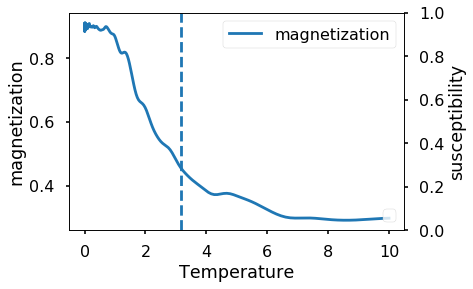

In [42]:
# extract model temps
idx = np.argmin(abs(mag - .5 * mag.max()))
m.t = temps[idx]

# magnetization plot
fig, ax = plt.subplots()
tax = ax.twinx()
# tax.scatter(temps, sus, color = 'black', label = 'susceptibility')
ax.plot(temps, mag, label = 'magnetization')
ax.axvline(m.t, linestyle = 'dashed')
ax.set(xlabel = 'Temperature', ylabel = 'magnetization')
tax.set(ylabel = 'susceptibility')
tax.legend(loc = 'lower right'); ax.legend()
fig.show()

/home/casper/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


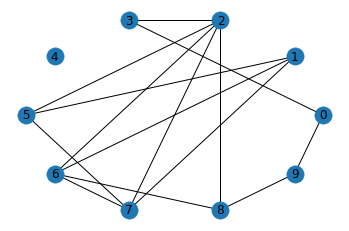

In [43]:
fig, ax = plt.subplots()
nx.draw(g, pos = nx.circular_layout(g), ax = ax, with_labels = 1)
fig.show()

In [ ]:
# compute mi over time
from Toolbox import infcy as information
nSamples = int(3e4)
step     = 1000
repeats  = int(2e4)
deltas   = 50

snapshots = information.getSnapShots(m, nSamples, step)
conditional, px, mi = information.runMC(m, snapshots, deltas, repeats)

  0%|          | 0/631 [00:00<?, ?it/s]

done
Found 631 states
Delta =  3.49 sec
Decoding..
starting runs


 77%|███████▋  | 483/631 [01:00<00:17,  8.35it/s]

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


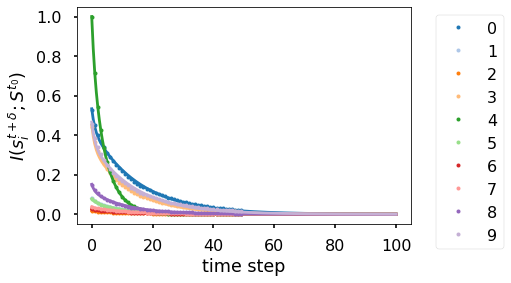

In [5]:
from Utils.plotting import fit

colors = plt.cm.tab20(range(m.nNodes))
params = dict(\
             bounds = (0, np.inf),\
             jac = 'cs', maxfev = 100000)
func = lambda x, a, b, c, d, e, f:  b * np.exp(-c * (x - f)) + d * np.exp(- (x - e) ) 
# func = lambda x, a, b: 
coeffs, _  = fit(mi.T, func, params = params)


x = np.linspace(0, 2 * deltas, 200)

fig, ax = plt.subplots()
for k, v in m.mapping.items():
    ax.plot(mi[:, v], linestyle = 'none', marker = 'o', markersize = 4, label = k, color = colors[v])
    ax.plot(x, func(x, *coeffs[v]), color = colors[v])
# ax.set(yscale = 'log', xscale = 'log')
ax.set(xlabel = 'time step', ylabel = r'$I(s_i^{t+\delta} ; S^{t_0})$')
ax.legend(bbox_to_anchor = (1.05,1))
fig.show()

In [6]:
import scipy
aucs = np.asarray([\
                  scipy.integrate.quad(lambda x: func(x, *c), 0, np.inf)[0]\
                   for c in coeffs\
                  ])
for k, v in m.mapping.items():
    print(f'Node {k} had {aucs[v]}')

Node 0 had 6.669730727343939
Node 1 had 0.6861045907218384
Node 2 had 0.1941383626653554
Node 3 had 4.482793030629788
Node 4 had 3.8420097938207065
Node 5 had 0.6495406370461323
Node 6 had 0.3019892631728913
Node 7 had 0.4427559263909575
Node 8 had 1.3370943752135165
Node 9 had 5.133536484004131


In [12]:
from Utils import stats

nudges = np.logspace(-2, 1, 5)
nudges[-1] = np.inf
# nudges = -nudges
TARGET = m.rmapping[np.argmax(aucs)]
sensitivity = np.zeros((nudges.size, m.nNodes, deltas))
for idx, nudge in enumerate(nudges):
    for node, nidx in m.mapping.items():
        tmp = {node : nudge}
        m.nudges = tmp
        cpx, p, cmi = information.runMC(m, snapshots, deltas, repeats)
        tmp = stats.JS(px, p).sum(-1)
        sensitivity[idx, nidx] = tmp
    

  0%|          | 0/131 [00:00<?, ?it/s]

Decoding..
starting runs


100%|██████████| 131/131 [00:15<00:00,  7.71it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.48 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.64 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.49 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.60 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.01 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.54 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.94 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.65 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.41 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.87 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  16.20 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.81 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.66 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.93 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.70 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.11 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  16.21 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  16.94 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.12 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.82 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.78 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.02 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.80 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.75 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.21 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.28 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.87 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.67 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.78 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.67 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.22 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.01 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.97 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.64 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.52 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.15 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.88 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.45 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.13 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.87 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.36 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.15 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  14.79 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.27 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.16 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.34 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.31 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.64 sec
Decoding..
starting runs


  0%|          | 0/131 [00:00<?, ?it/s]

Delta =  15.48 sec
Decoding..
starting runs


100%|██████████| 131/131 [00:15<00:00,  7.34it/s]

Delta =  15.20 sec


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


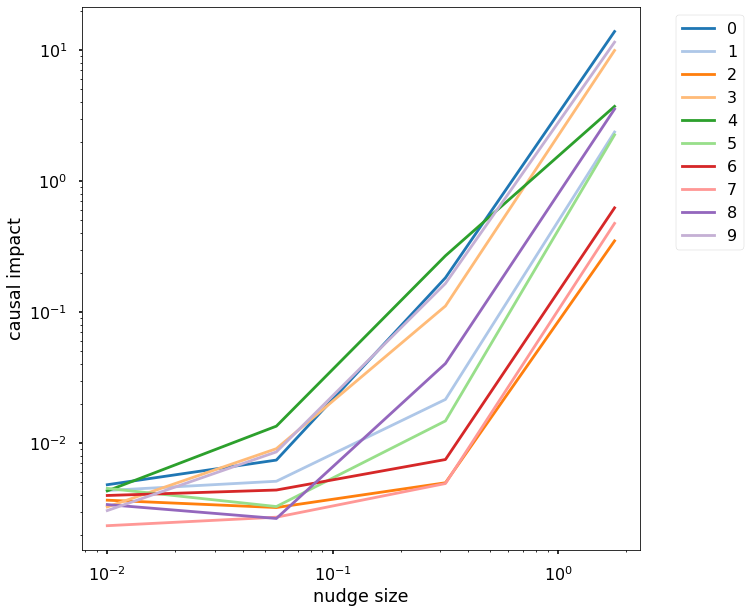

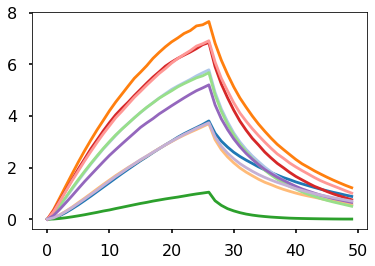

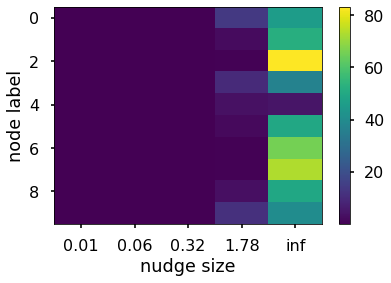

In [41]:
edited_sens = sensitivity.copy()
# # threshold = 1e-3
# # edited_sens[..., -1:] = 0 # try forcing the results
# aucs_causal = np.zeros((sensitivity.shape[:-1]))
# f = lambda x, a, b, c, d, e, f:  a * np.exp(- b * x) # + c * np.exp(-d * (x - e))
# for idx, i in enumerate(edited_sens):
#     s = i.shape
#     i = i.reshape(-1)
#     i = (i - i.min()) / (i.max() - i.min())
#     i[i<threshold] = 0
#     i = i.reshape(s)
#     edited_sens[idx] = i
#     coeffs, _ = fit(i[:, deltas // 2:], f, params = params)
#     for node, j in enumerate(i):
#         tmp = lambda x: f(x, *coeffs[node]) 
#         aucs_causal[idx, node] = scipy.integrate.quad(tmp, -1, np.inf)[0]
y = edited_sens[..., deltas // 2:]
aucs_causal = scipy.integrate.simps(y, axis = -1)
fig, ax = plt.subplots(figsize = (10, 10))
for idx, nsens in enumerate(aucs_causal.T):
    ax.plot(nudges, nsens, '-', color = colors[idx], label = m.rmapping[idx])
ax.legend(bbox_to_anchor = (1.05, 1))
ax.set(xlabel = 'nudge size', ylabel = 'causal impact',\
#       )
     xscale = 'log', yscale = 'log')
fig.show()

idx = -1
fig, ax = plt.subplots()

for node, v in m.mapping.items():
    ax.plot(edited_sens[idx, v],  color = colors[v], label = node)
fig.show()

# print(nudges)
# for idx, i in enumerate(aucs_causal.T):
#     print(m.rmapping[idx], i)
fig, ax = plt.subplots()
h = ax.imshow(aucs_causal.T, aspect = 'auto')
ax.set(xticklabels = np.round(nudges,2), xticks = np.arange(nudges.size))
ax.set(xlabel = 'nudge size', ylabel = 'node label', \
      )
fig.colorbar(h)
fig.show()